# FinOpt — Simulation & Optimization Demo

This notebook showcases the **current MVP** of FinOpt:

- Income modeling → monthly contributions
- Three-case deterministic scenarios (base/optimistic/pessimistic)
- Monte Carlo simulation (IID lognormal)
- Optimization solvers: minimum contribution (closed-form), minimum time (binary search)
- Goal evaluation & chance-constraints
- (Bonus) Multi-asset portfolio simulation


# 0) Setup

In [1]:
# --- Path setup: add project root so "src" is importable ---
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from datetime import date

import matplotlib.pyplot as plt

# --- Standard libs ---
import numpy as np
import pandas as pd

# from src.goals import Goal, evaluate_goals

# --- FinOpt modules (desde /src) ---
from src.income import FixedIncome, IncomeModel, VariableIncome
from src.investment import Portfolio, Account
from src.utils import summary_metrics

# IncomeModel –  Seasonality and Contributions

## Configuration

In [2]:
# ---------------------------------------------------------------------------
# Income Simulation Configuration
# ---------------------------------------------------------------------------

from datetime import date

# --- Seasonality pattern for variable income (12 months, Jan–Dec) ---
# Values represent multiplicative factors relative to the base income.
seasonality_variable = [
    0.00,  # Jan
    0.00,  # Feb
    0.00,  # Mar
    1.32,  # Apr
    1.32,  # May
    1.36,  # Jun
    1.24,  # Jul
    1.1,  # Aug
    0.5,  # Sep
    0.9,  # Oct
    1.0,  # Nov
    1.31,  # Dec
]

# --- Annual contribution fractions for fixed income (12 months) ---
# Each value represents the fraction of income to contribute for that month.
monthly_contrib_fixed = [
    0.30,  # Jan
    0.30,  # Feb
    0.30,  # Mar
    0.32,  # Apr
    0.35,  # May
    0.35,  # Jun
    0.33,  # Jul
    0.33,  # Aug
    0.20,  # Sep: reduced contribution (holidays)
    0.30,  # Oct
    0.30,  # Nov
    0.15,  # Dec: reduced contribution (Christmas)
]

## Create IncomeModel instance

In [3]:
# --- Create IncomeModel instance ---
income = IncomeModel(
    fixed=FixedIncome(
        base=1_480_000.0,       # Base monthly salary
        annual_growth=0.05,     # 5% nominal annual growth
        salary_raises={
            date(2026, 4, 1): 400_000,  # Salary Raises 200k in April 2026
            date(2027, 4, 1): 400_000  # Salary Raises 200k in April 2027
        }  
    ),
    variable=VariableIncome(
        base=150_000.0,         # Base variable income (e.g., bonuses, side jobs)
        seasonality=seasonality_variable,
        sigma=0.10,             # 10% monthly Gaussian noise
        floor=0,         # Minimum monthly income
        cap=400_000.0,          # Maximum monthly income
        annual_growth=0.0,      # No annual growth for variable component
    ),
)

# --- Simulation parameters ---
months = 24
start = date(2025, 9, 1)  # Start date for projection

# --- Define annual contribution fractions for both income streams ---
income.monthly_contribution = {
    "fixed": monthly_contrib_fixed,  # Fraction of fixed income to contribute
    "variable": [1.0] * 12,          # 100% of variable income each month
}

# --- Compute monthly contributions ---
# Fractions are automatically rotated according to `start` and repeated cyclically.
contributions = income.contributions(months=months, start=start)

# Display first few months
contributions.head()

2025-09-01    377357.747509
2025-10-01    562194.592575
2025-11-01    590609.816064
2025-12-01    426585.233016
2026-01-01    451279.982426
Freq: MS, Name: contribution, dtype: float64

In [4]:
# --- Compute monthly contributions ---
# Fractions are automatically rotated according to `start` and repeated cyclically.
contributions = income.contributions(months=months, start=start, n_sims=500, output='array')

# Display first few months
print('Shape:', contributions.shape)
print('Array:', contributions)

Shape: (500, 24)
Array: [[ 372091.88967173  595802.86593376  615621.96392977 ... 1060675.13239893
  1003446.65141722  975779.45748489]
 [ 377467.09040293  557762.14520351  602518.38944004 ... 1038044.25777409
  1004758.27038125  957387.18619459]
 [ 362025.18458044  600574.58956308  595361.93825377 ... 1050264.19633419
  1023846.85416108  967000.97882781]
 ...
 [ 384330.23671646  564931.7288098   624255.6267963  ... 1087938.20252498
   982918.79304469  967076.03457177]
 [ 387585.89758681  573298.29616265  574295.18041249 ... 1046205.13234795
   985250.94574186  981682.62307234]
 [ 371309.47819888  561739.80172221  589256.6391465  ... 1064339.27827202
   965366.03165304  952299.75963022]]


In [5]:
income

IncomeModel(horizon=12 months, total_income=19668009.51, total_fixed=18163414.74, total_variable=1504594.77, mean_total=1639000.79, fixed_share=92.4%, variable_share=7.6%)

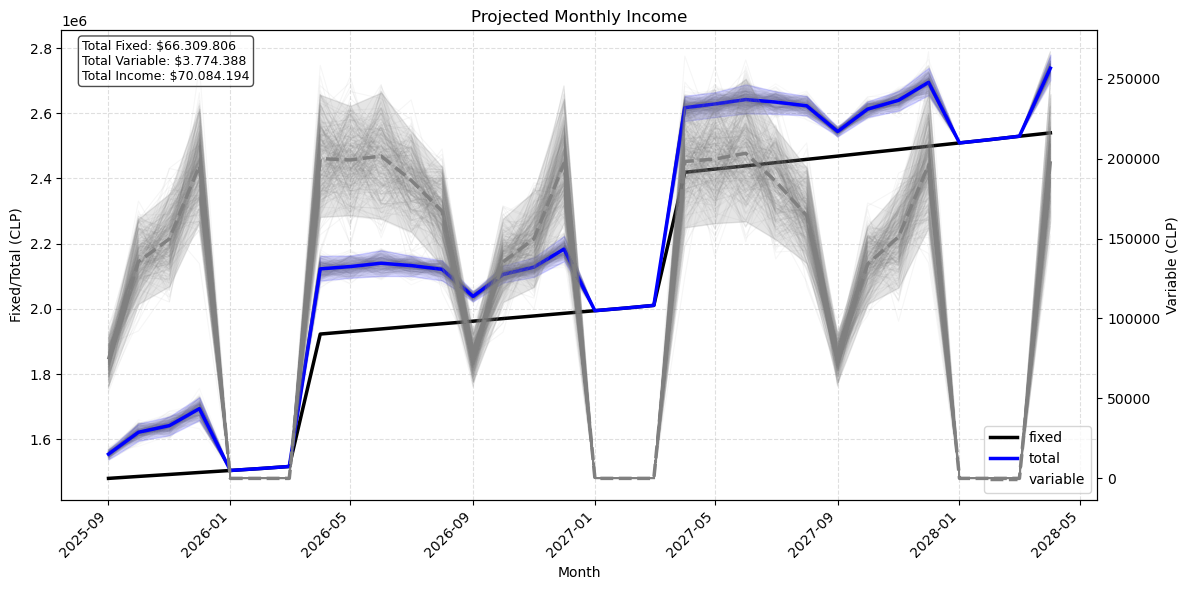

In [7]:
# ==============================
# Income Projection Simulation
# ==============================
from datetime import date

# --- Simulation parameters ---
months = 32
start_date = date(2025, 9, 1)  # Projection start date

# Optional: define custom colors for the plot
plot_colors = {
    "fixed": "black",
    "variable": "gray",
    "total": "blue"
}

# --- Generate and display the projection plot ---
fig, ax = income.plot(
    mode="income",
    months=months,
    start=start_date,
    dual_axis=True,
    title="Projected Monthly Income",
    colors=plot_colors,
    show_trajectories=True,
    trajectory_alpha=0.07,
    show_confidence_band=True,
    n_simulations=300,
    confidence=0.95,
    return_fig_ax=True
)

# Optional: adjust layout for better spacing
fig.tight_layout()

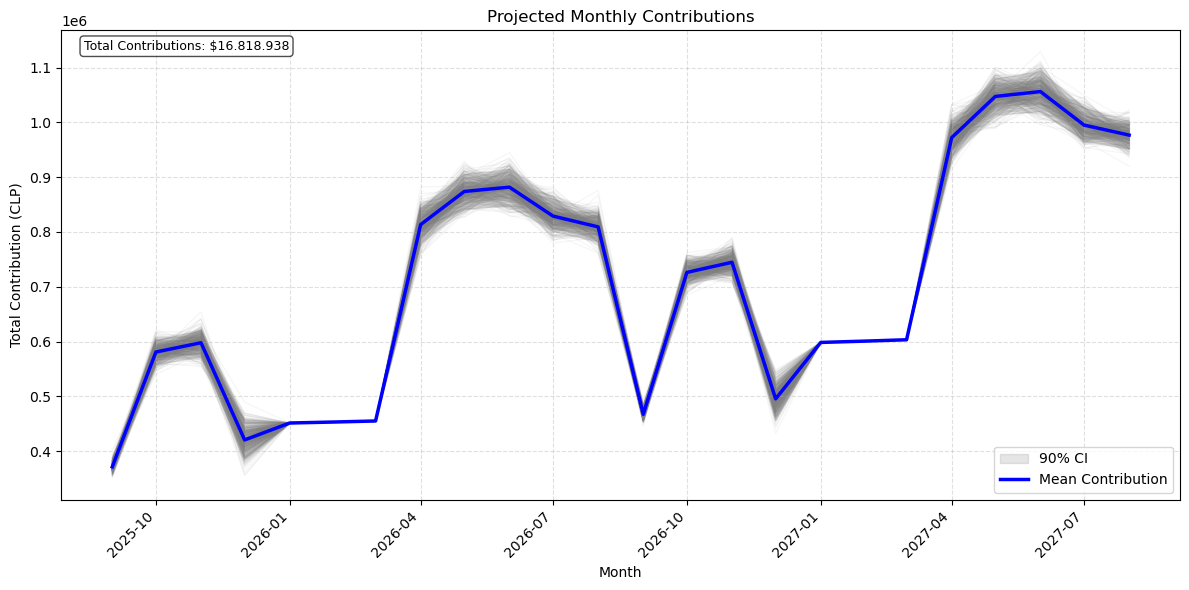

In [18]:
# ==============================
# Contribution Projection Simulation
# ==============================

from datetime import date

# --- Simulation parameters ---
months = 24
start_date = date(2025, 9, 1)  # Projection start date

contrib_colors = {
    "total": "blue",
    "ci": "gray"  # Color de la banda de confianza
}

# --- Generate and display the contributions plot ---
fig, ax = income.plot(
    mode="contributions",
    months=months,
    start=start_date,
    title="Projected Monthly Contributions",
    colors=contrib_colors,
    show_confidence_band=True,
    show_trajectories=True,
    confidence=0.9,
    n_simulations=500,
    return_fig_ax=True
)

# Optional: adjust layout for better spacing
fig.tight_layout()

In [16]:
# Summary for 24 months
summary_24m = income.summary(months=24, start=date(2025, 9, 1))
print("=== Summary (24 months) ===")
print(summary_24m)

=== Summary (24 months) ===
months                                24.00
total_fixed                     46277575.44
total_variable                   3013968.40
total_income                    49291543.84
mean_fixed                       1928232.31
mean_variable                     125582.02
mean_total                       2053814.33
std_variable                       81828.33
coefvar_variable                       0.65
fixed_share                            0.94
variable_share                         0.06
min_variable                           0.00
max_variable                      210449.92
pct_variable_below_threshold            NaN
dtype: float64


# Recursive vs. Closed-Form Wealth Verification

In this experiment, we simulate the monthly wealth evolution of multiple portfolios using an income model composed of fixed and variable cash flows. Wealth is computed in two ways:

1. **Recursive form**:  
   Calculated month by month by adding the monthly contribution and applying the corresponding return:
   $$
   W_{t+1}^m = (W_t^m + A_t^m) \cdot (1 + R_t^m)
   $$

2. **Closed-form (affine) form**:  
   Wealth is obtained directly as a linear-affine function of the contributions and the initial wealth:
   $$
   W_{t+1}^m = W_0^m \prod_{r=0}^{t} (1 + R_r^m) + \sum_{s=0}^{t} A_s^m \prod_{r=s}^{t} (1 + R_r^m)
   $$

The goal is to verify that both formulas coincide in practice, demonstrating that **the recursive version is not necessary** and that optimization problems involving the allocation weights `X` will be **linear-affine** with respect to `X`.

In [15]:
# Refactor: comparar wealth_recursive vs wealth usando investment.py
from datetime import date
import numpy as np
import matplotlib.pyplot as plt

# parámetros
months = 24
seed = 42
start_date = date(2025, 6, 1)

# contribuciones reproducibles
contrib = income.contributions(months=months, start=start_date, seed=seed)
A = np.asarray(contrib.values) if hasattr(contrib, "values") else np.asarray(contrib).flatten()

# rng para reproducibilidad de pesos
rng = np.random.default_rng(seed)

# -----------------------------
# Instanciar Portfolio con M cuentas
# -----------------------------
M = 3  # número de cuentas/portafolios
accounts = [
    Account.from_gaussian(
        name=f"acc_{i+1}", 
        annual_return=0.07, 
        annual_volatility=0.000001, 
        initial_wealth=100000.0
    )
    for i in range(M)
]
portfolio = Portfolio(accounts=accounts)

# -----------------------------
# Samplear retornos usando el método del Portfolio
# -----------------------------
R = portfolio.returns(months=months, seed=seed)  # shape (months, M)

# -----------------------------
# Generar política de asignación aleatoria normalizada
# -----------------------------
X = rng.uniform(0, 1, size=(months, M))
X /= X.sum(axis=1, keepdims=True)  # normalizar filas para que sumen 1 por mes

# -----------------------------
# Llamar a las implementaciones del módulo
# -----------------------------
W_rec = portfolio.wealth_recursive(contributions=A, allocation_policy=X, returns=R)

# wealth ahora toma la riqueza inicial directamente de las cuentas
W_closed = portfolio.wealth(contributions=A, allocation_policy=X, returns=R)

# -----------------------------
# Comparación
# -----------------------------
diff = W_rec - W_closed
print("shape W_rec:", W_rec.shape)
print("shape W_closed:", W_closed.shape)
print("Máxima diferencia absoluta:", np.abs(diff).max())

# comprobación numérica estricta
if not np.allclose(W_rec, W_closed, rtol=1e-9, atol=1e-10):
    print("Advertencia: las trayectorias no son exactamente iguales dentro de tolerancia numérica muy estricta.")
else:
    print("OK: wealth_recursive y wealth coinciden dentro de tolerancia numérica.")


shape W_rec: (25, 3)
shape W_closed: (25, 3)
Máxima diferencia absoluta: 1.862645149230957e-09
OK: wealth_recursive y wealth coinciden dentro de tolerancia numérica.


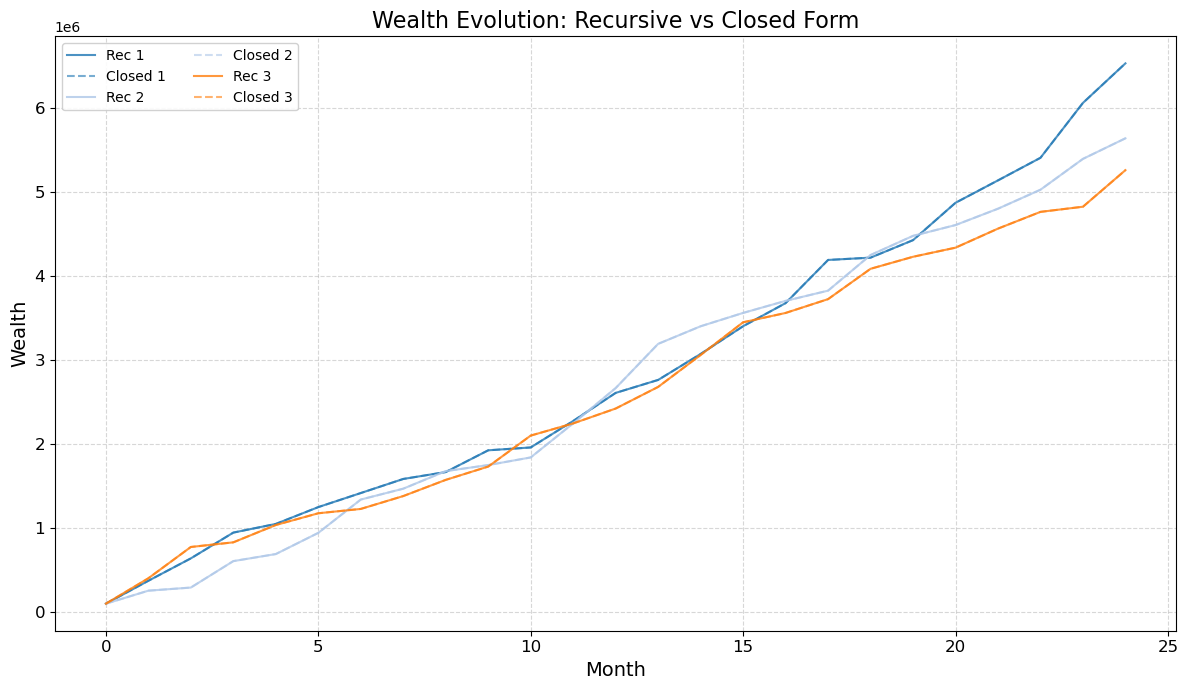

In [16]:
# -----------------------------
# Visualización embellecida
# -----------------------------
plt.figure(figsize=(12, 7))
months_idx = np.arange(0, months + 1)

# Paleta de colores
cmap = plt.get_cmap("tab20")
for m in range(M):
    color = cmap(m % 20)
    # Trayectoria recursive
    plt.plot(months_idx, W_rec[:, m], color=color, lw=1.5, alpha=0.8, label=f"Rec {m+1}" if m < 5 else "")
    # Trayectoria closed (línea punteada)
    plt.plot(months_idx, W_closed[:, m], color=color, lw=1.5, ls='--', alpha=0.6, label=f"Closed {m+1}" if m < 5 else "")

plt.xlabel("Month", fontsize=14)
plt.ylabel("Wealth", fontsize=14)
plt.title("Wealth Evolution: Recursive vs Closed Form", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10, ncol=2, loc='upper left', framealpha=0.9)
plt.tight_layout()
plt.show()


# Monte Carlo Simulation of Wealth Evolution

This cell simulates the evolution of a single portfolio over 24 months using **Monte Carlo** with `N = 1000` scenarios to study **volatility** and outcome distribution.

### Steps:

1. **Income model**: Combines fixed salary (with growth and raises) and variable income (seasonal, noisy, capped/floored).  
2. **Portfolio**: One account with specified return, volatility, and initial wealth.  
3. **Simulation**: For each scenario, generate monthly contributions and random returns, then compute wealth evolution.  
4. **Analysis**: Compute mean and standard deviation to capture average trajectory and 95% confidence interval.  
5. **Visualization**:  
   - Gray lines: individual Monte Carlo trajectories.  
   - Blue line & shaded band: mean wealth and 95% CI.  
   - Right-side histogram: distribution of final wealth, showing where trajectories converge.  

This approach provides an intuitive view of **risk, dispersion, and expected outcomes** over time.


NameError: name 'final_wealth' is not defined

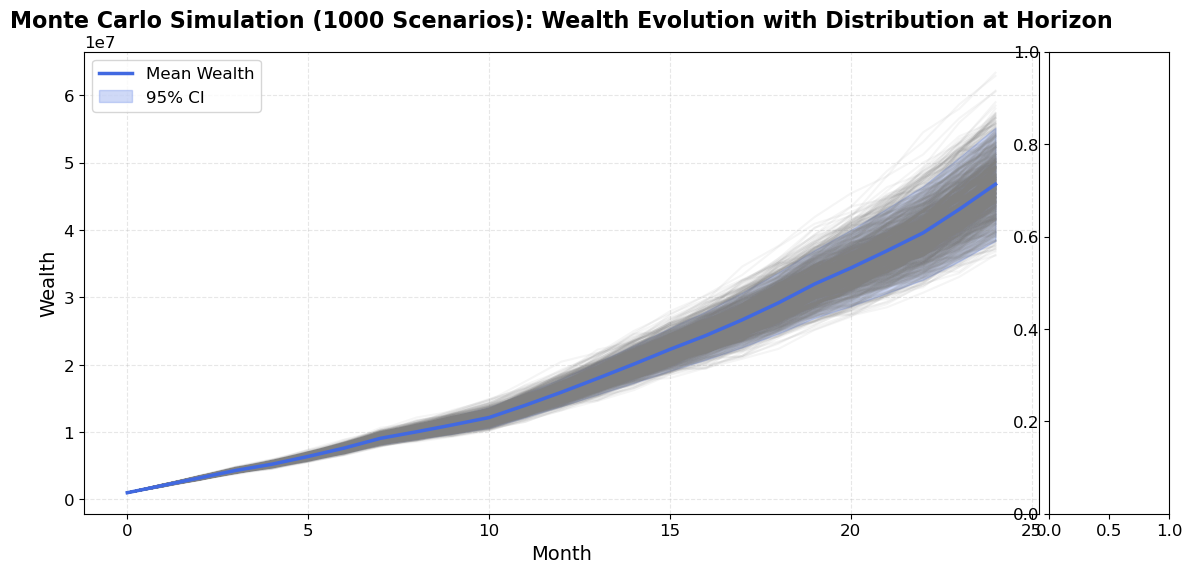

In [17]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from datetime import date

# -----------------------------
# Parámetros de simulación
# -----------------------------
months = 24        # horizonte temporal de 3 años
N = 1000           # número de escenarios
seed = 42
start_date = date(2025, 6, 1)
months_idx = np.arange(0, months + 1)

# --- Create IncomeModel instance ---
income = IncomeModel(
    fixed=FixedIncome(
        base=1_480_000.0,       # Base monthly salary
        annual_growth=0.05,     # 5% nominal annual growth
        salary_raises={
            date(2026, 4, 1): 400_000,  # Salary Raises 200k in April 2026
            date(2027, 4, 1): 400_000  # Salary Raises 200k in April 2027
        }  
    ),
    variable=VariableIncome(
        base=400_000.0,         # Base variable income (e.g., bonuses, side jobs)
        seasonality=seasonality_variable,
        sigma=0.01,             # 10% monthly Gaussian noise
        floor=0,         # Minimum monthly income
        cap=4_000_000.0,          # Maximum monthly income
        annual_growth=0.0,      # No annual growth for variable component
    ),
)

# -----------------------------
# Instanciar cartera única
# -----------------------------
account = Account.from_gaussian(
    name="main",
    annual_return=0.90,
    annual_volatility=0.10,
    initial_wealth=1_000_000.0
)
portfolio = Portfolio(accounts=[account])

# -----------------------------
# Simular N escenarios
# -----------------------------
wealth_scenarios = np.zeros((months + 1, N))

rng = np.random.default_rng(seed)

for i in range(N):
    contrib = income.contributions(months=months, start=start_date)
    A = np.asarray(contrib.values) if hasattr(contrib, "values") else np.asarray(contrib).flatten()
    R = portfolio.returns(months=months, seed=rng.integers(0, 1_000_000))
    X = np.ones((months, 1))  # toda la contribución va al único account
    wealth_scenarios[:, i] = portfolio.wealth(contributions=A, allocation_policy=X, returns=R).flatten()

# -----------------------------
# Análisis de volatilidad
# -----------------------------
# Calcular media y desviación estándar mensual
wealth_mean = wealth_scenarios.mean(axis=1)
wealth_std = wealth_scenarios.std(axis=1)

# -----------------------------
# Visualización Monte Carlo
# -----------------------------
mpl.rcParams.update({'font.size': 12})  # tamaño de fuente general

fig, ax = plt.subplots(figsize=(14,6))

# Trayectorias Monte Carlo
for i in range(N):
    ax.plot(months_idx, wealth_scenarios[:, i], color='gray', alpha=0.08)

# Media y CI
ax.plot(months_idx, wealth_mean, color='royalblue', lw=2.5, label='Mean Wealth')
ax.fill_between(
    months_idx,
    wealth_mean - 1.96*wealth_std,
    wealth_mean + 1.96*wealth_std,
    color='royalblue', alpha=0.25, label='95% CI'
)

# Labels y grid
ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Wealth", fontsize=14)
ax.set_title(f"Monte Carlo Simulation ({N} Scenarios): Wealth Evolution with Distribution at Horizon", 
             fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.3)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='upper left', fontsize=12)

# Eje extra para histograma
divider = make_axes_locatable(ax)
ax_hist = divider.append_axes("right", size=1.2, pad=0.1)
ax_hist.hist(final_wealth, bins=40, orientation='horizontal', 
             color='mediumseagreen', alpha=0.6, edgecolor='black')
ax_hist.set_xlabel("Count", fontsize=12)
ax_hist.set_ylim(ax.get_ylim())
ax_hist.tick_params(axis='y', labelsize=12)
ax_hist.grid(False)

plt.tight_layout()
plt.show()

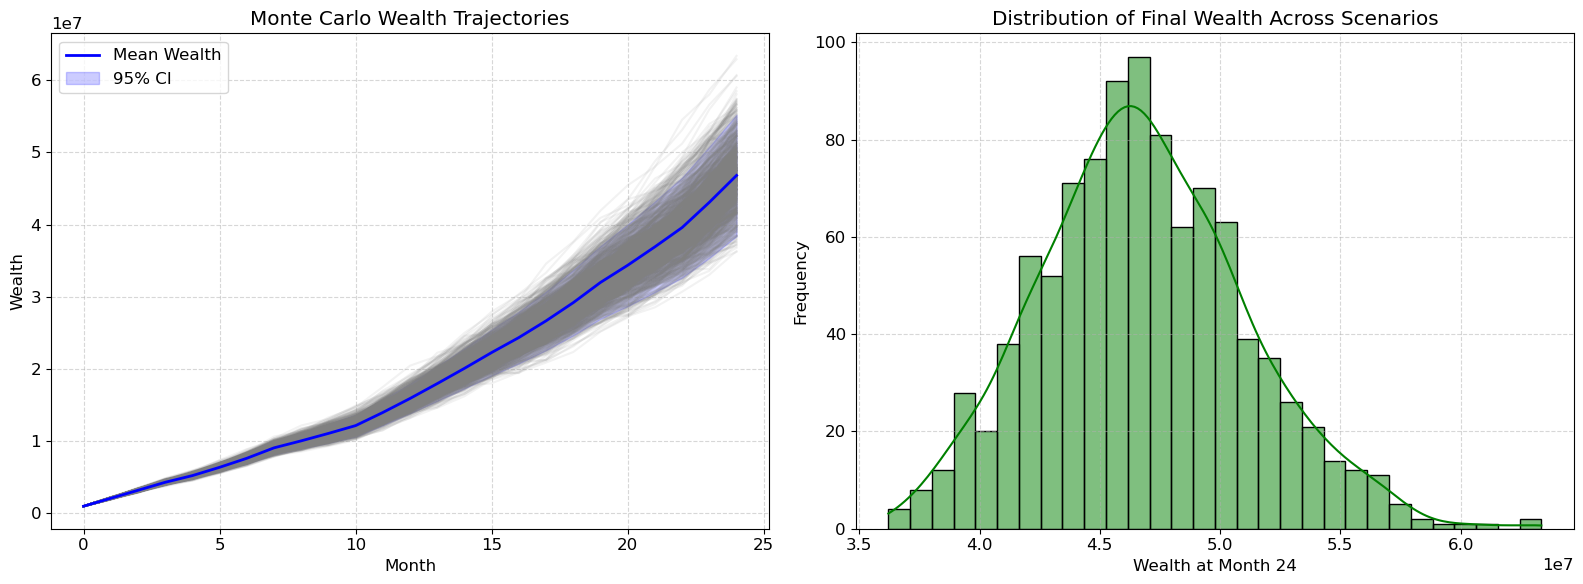

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

months_idx = np.arange(0, months + 1)

# Crear figura con 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# -----------------------------
# Panel 1: trayectorias Monte Carlo
# -----------------------------
for i in range(N):
    axes[0].plot(months_idx, wealth_scenarios[:, i], color='gray', alpha=0.1)
axes[0].plot(months_idx, wealth_mean, color='blue', lw=2, label='Mean Wealth')
axes[0].fill_between(
    months_idx,
    wealth_mean - 1.96 * wealth_std,
    wealth_mean + 1.96 * wealth_std,
    color='blue',
    alpha=0.2,
    label='95% CI'
)
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Wealth")
axes[0].set_title("Monte Carlo Wealth Trajectories")
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend()

# -----------------------------
# Panel 2: distribución final de riqueza
# -----------------------------
final_wealth = wealth_scenarios[-1, :]
sns.histplot(final_wealth, bins=30, kde=True, ax=axes[1], color='green')
axes[1].set_xlabel("Wealth at Month {}".format(months))
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Final Wealth Across Scenarios")
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
